In [1]:
import contextlib
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords, wordnet
import mmh3
import numpy as np
import contextlib
import numpy as np
import string
import nltk
import json

import spacy
import lemminflect
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
POS = ("CC", "CD", "DT", "EX", "FW", "IN", "JJ", "JJR", "JJS", "LS", "MD", "NN", "NNP", "NNPS", "NNS", "PDT", "PRP", "PRP$", "RB", "RBR", "RBS", "RP", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "WDT", "WP", "WP$", "WRB")

def lemmatize(word): # Takes a word and uses the spacy lemmatizer to return the lemmatized form
    token = nlp(str(word))[0]
    lemma = token.lemma_
    inflections = {token._.inflect(pos) for pos in POS} # returns the inflection of the lemmatized token. (ex: run -> {'ran', 'run', 'runner', 'runnest', 'running', 'runs'} )
    return lemma, inflections

def tokenize(sentence): # Tokenizes a sentence and lemmatizes the words within
    tokenized = nlp(sentence.translate(str.maketrans('', '', string.punctuation)))
    return [token.lemma_ for token in tokenized if token.lemma_.lower() not in en_stopwords and wordnet.synsets(token.lemma_)] # disregards lemmatized token if it's in list of stopwords or not in english dictionary (wordnet)

nltk.download('stopwords')
nltk.download('wordnet')
en_stopwords = set(stopwords.words('english'))

data = [] # loads the datasets as binaries 
for i in range (1, 1731):
    with contextlib.suppress(FileNotFoundError):
        with open(f'data/fairy_tales/{i}.txt', 'r', encoding='ISO-8859-1') as f:
            data.append(f.read())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yourui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Yourui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data[0]

'THE LONG WAPPERS, AND THEIR TRICKS\n\n\nIn his rambles in Belgium, the story-teller found no parts of any city\nin the land equal in interest to those of old Antwerp. If he sauntered\ndown toward evening, into the narrow streets and through the stone\ngateway, blackened with age, under which the great Charles V. rode, the\nfairies and funny folks seemed almost as near to him as the figures in\nreal history. Here, many a prince or princess made their â\x80\x9cjoyous\nentry,â\x80\x9d into the wonderful city of Brabo, the boy hero, who slew the\ncruel giant Antigonus and cut off his cruel hands.\n\nHere, the story-teller noticed a great many images of the Virgin Mary;\nwhereas, in the newer parts of the city, there were few or none. They\nwere usually set in the house corners, where two streets came together.\nInquiring into the reason of this, he discovered a new kind of Belgian\nfairy, the Wapper, famous for his long legs and funny tricks. Here were\nfairies on stilts.\n\nThis mischiev

In [3]:
def hash_token(token, bits):
    representation = np.zeros(bits)
    
    for i in range(3):
        digest = mmh3.hash(token, i) % bits
        representation[digest] = 1
    return representation

In [4]:
with open('data/fairytales_word_tf-idfs.json', 'r') as f:
    tf_idfs = json.load(f)

In [5]:
def generate_vector(word, tokenized_sentence, bits, deltas):
    representations = []
    indices = [i for i, x in enumerate(tokenized_sentence) if x == word]
    for index in indices:
        instance_representation = np.zeros(bits)

        for delta in deltas:
            if index + delta < 0:
                continue
            with contextlib.suppress(IndexError):
                adjacent_word = tokenized_sentence[index + delta]
                try:
                    tf_idf = tf_idfs[word][adjacent_word]
                except KeyError:
                    tf_idf = 0
                instance_representation += np.array(list(hash_token(adjacent_word, bits))) * tf_idf
        
        representations.append(instance_representation.tolist())
    return representations

In [6]:
def extract_vectors(word, n_occurrences=10000, deltas=None, bits=32):
    if deltas is None:
        deltas = [-4, -3, -2, -1, 1, 2, 3, 4]
    word, inflections = lemmatize(word)

    occurrences = 0
    representations = []

    for i, row in enumerate(data):
        sentences = sent_tokenize(row.lower())

        for sentence in sentences:
            if inflections.intersection(set(sentence.lower().split())):
                tokenized = tokenize(sentence)
                representations += generate_vector(word, tokenized, bits, deltas)

        if i % 10 == 0:
            print(f'"{word}", {i}th row processed, {occurrences}/{n_occurrences} occurrences')

    return representations

In [7]:
# keep only the most frequently occurring words next to the target word (ex: 1000+ occurrences) + aggregate those words + collect data
    # Table 1: Most frequent words
    # Table 2: Most frequent words with count vectors
# test discarding bits with high variance values

In [8]:
def store_encoding(word, fname, args):
    vector = extract_vectors(word, **args)
    
    with open(fname, 'r') as f:
        vectors = json.load(f)
    vectors[word] = vector
    with open(fname, 'w') as f:
        json.dump(vectors, f, indent=4)

In [9]:
words = ['girl', 'boy', 'prince', 'princess', 'king', 'queen', 'long', 'say', 'water']
for word in words:
    store_encoding(word, 'data/fairytales_vectors.json', {'n_occurrences':None, 'deltas': [-4, -3, -2, -1, 1, 2, 3, 4], 'bits':32})

"girl", 0th row processed, 0/None occurrences
"girl", 10th row processed, 0/None occurrences
"girl", 20th row processed, 0/None occurrences
"girl", 30th row processed, 0/None occurrences
"girl", 40th row processed, 0/None occurrences
"girl", 50th row processed, 0/None occurrences
"girl", 60th row processed, 0/None occurrences
"girl", 70th row processed, 0/None occurrences
"girl", 80th row processed, 0/None occurrences
"girl", 90th row processed, 0/None occurrences
"girl", 100th row processed, 0/None occurrences
"girl", 110th row processed, 0/None occurrences
"girl", 120th row processed, 0/None occurrences
"girl", 130th row processed, 0/None occurrences
"girl", 140th row processed, 0/None occurrences
"girl", 150th row processed, 0/None occurrences
"girl", 160th row processed, 0/None occurrences
"girl", 170th row processed, 0/None occurrences
"girl", 180th row processed, 0/None occurrences
"girl", 190th row processed, 0/None occurrences
"girl", 200th row processed, 0/None occurrences
"gi

In [10]:
with open('data/fairytales_vectors.json', 'r') as f:
    data = json.load(f)

# removes newlines in lists for readability
import re
def repl_func(match: re.Match):
    return " ".join(match.group().split())
json_str = json.dumps(data, indent=4)
json_str = re.sub(r"(?<=\[)[^\[\]]+(?=])", repl_func, json_str)

with open('data/fairytales_vectors.json', 'w') as f:
    f.write(json_str)

In [11]:
import random

points = []
comparing = ['boy', 'girl', 'prince', 'princess']
for word in comparing:
    points.extend([word, np.array(row)] for row in random.sample(data[word], 1000))

random.shuffle(points)

In [12]:
labels = np.array([point[0] for point in points])
lookup, clabels = np.unique(labels, return_inverse=True)
vectors = np.array([point[1] for point in points])

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(vectors)

/var/folders/h1/88vswkjs65x3v7m1ytlwgpy40000gp/T/ipykernel_5824/3346843112.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(comparing))


<Figure size 500x500 with 0 Axes>

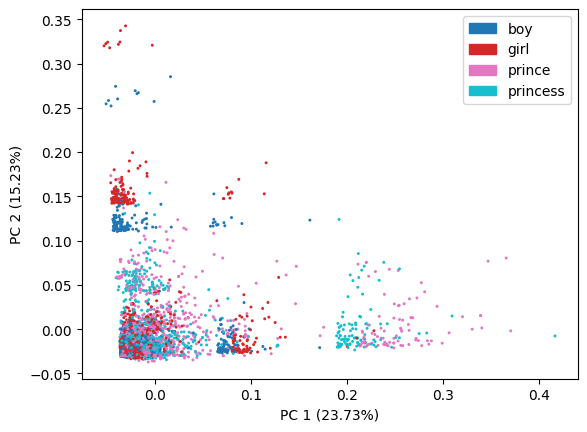

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

cmap = plt.cm.get_cmap('tab10', len(comparing))

plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.scatter(features_pca[:,0], features_pca[:,1], c=clabels, cmap='tab10', s=5, marker='.')

# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

plt.legend([mpatches.Patch(color=cmap(b)) for b in range(len(comparing))], lookup)

plt.savefig('pca.png', dpi=300)
plt.show()